<a href="https://colab.research.google.com/github/lucasocarvalhos/skimlit_project/blob/main/model_training_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit Model

Training model with the 200k dataset, as seen in the references bellow:

> Dataset Paper <br>
https://arxiv.org/pdf/1710.06071.pdf

> Neural Network Paper <br>
https://arxiv.org/pdf/1612.05251.pdf

# Helper functions

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py # thanks to zerotomastery

--2022-12-29 11:35:00--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-29 11:35:00 (121 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [2]:
def get_lines(filename):
  """
  Reads a text filename and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target filename
  """

  with open(filename, "r") as f:
    return f.readlines()

In [3]:
def txt_to_dicts(filename):
  """
  Returns a list of dicts of abstract line data.
  Takes in filename, reads it and sorts through each line, extracting things
  like the target label, text of the sentence, how many sentences are in the 
  abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename)

  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      
      for k, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_txt_split = abstract_line.split("\t")

        line_data["target"] = target_txt_split[0]
        line_data["text"] = target_txt_split[1].lower()
        line_data["line_number"] = k
        line_data["total_lines"] = len(abstract_line_split) - 1

        abstract_samples.append(line_data)

    else: 
      abstract_lines += line

  return abstract_samples

# Get data

In [4]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [5]:
import os

os.chdir("/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign")
!unzip "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip"

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
replace train.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
data_dir = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [7]:
# take txt files and put them all together in json lines
train_samples = txt_to_dicts(data_dir + "train.txt")
test_samples = txt_to_dicts(data_dir + "test.txt")
val_samples = txt_to_dicts(data_dir + "dev.txt")

In [8]:
len(train_samples), len(test_samples), len(val_samples)

(2211861, 29493, 28932)

> **Data to dataframe**

In [9]:
import pandas as pd

In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [11]:
train_df.head()

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10


# Preprocess data

## Get lists of sentences

In [12]:
train_sentences = train_df.text.values
val_sentences = val_df.text.values
test_sentences = test_df.text.values

len(train_sentences), len(val_sentences), len(test_sentences)

(2211861, 28932, 29493)

## One Hot Encode labels

In [13]:
from sklearn.preprocessing import OneHotEncoder

In [14]:
one_hot = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot.fit_transform(train_df.target.values.reshape(-1, 1))
val_labels_one_hot = one_hot.transform(val_df.target.values.reshape(-1, 1))
test_labels_one_hot = one_hot.transform(test_df.target.values.reshape(-1, 1))

## One Hot Encode line infos

In [15]:
import tensorflow as tf

In [16]:
# one hot encode sentences with less or equal than 15
train_line_number_one_hot = tf.one_hot(train_df.line_number.values, depth=15)
val_line_number_one_hot = tf.one_hot(val_df.line_number.values, depth=15)
test_line_number_one_hot = tf.one_hot(test_df.line_number.values, depth=15)

In [17]:
# one hot encode sentences with less or equal than 20
train_total_lines_one_hot = tf.one_hot(train_df.total_lines.values, depth=20)
val_total_lines_one_hot = tf.one_hot(val_df.total_lines.values, depth=20)
test_total_lines_one_hot = tf.one_hot(test_df.total_lines.values, depth=20)

## Map labels into integers

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df.target.values)
val_labels_encoded = label_encoder.transform(val_df.target.values)
test_labels_encoded = label_encoder.transform(test_df.target.values)

In [20]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

# Create Tokenizer and Embedding

## Embedding from TF Hub

In [21]:
import tensorflow_hub as hub

In [22]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

## Character-level tokenizer

In [43]:
import string
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers

In [24]:
# function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [25]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [36]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation

In [37]:
char_vectorizer = TextVectorization(max_tokens=len(alphabet)+2,
                                    output_sequence_length=290, # covers 95% of the length samples
                                    name="char_vectorizer")

In [39]:
# char dataset is too large, so putting in tf.data
train_chars_data = tf.data.Dataset.from_tensor_slices(train_chars).batch(64)
val_chars_data = tf.data.Dataset.from_tensor_slices(val_chars).batch(64)
test_chars_data = tf.data.Dataset.from_tensor_slices(test_chars).batch(64)

In [40]:
char_vectorizer.adapt(train_chars_data)

In [45]:
char_embed = layers.Embedding(input_dim=len(char_vectorizer.get_vocabulary()),
                              output_dim=25,
                              mask_zero=True,
                              name="char_level_embedding")

# Load data into tf.data.Dataset for better perfomance

**Train**

In [46]:
train_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                 train_total_lines_one_hot,
                                                 train_sentences,
                                                 train_chars))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_dataset = tf.data.Dataset.zip((train_data, train_labels)).batch(64).prefetch(tf.data.AUTOTUNE)

**Validation**

In [47]:
val_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                               val_total_lines_one_hot,
                                               val_sentences,
                                               val_chars))

val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_dataset = tf.data.Dataset.zip((val_data, val_labels)).batch(64).prefetch(tf.data.AUTOTUNE)

**Test**

In [48]:
test_data = tf.data.Dataset.from_tensor_slices((test_line_number_one_hot,
                                                test_total_lines_one_hot,
                                                test_sentences,
                                                test_chars))

test_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_dataset = tf.data.Dataset.zip((test_data, test_labels)).batch(64).prefetch(tf.data.AUTOTUNE)

# Buil Model

In [50]:
from scipy.linalg.decomp_svd import zeros
# Token model
token_inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(256, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# Char model
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(48))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# Line number model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32)
x = layers.Dense(128, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32)
y = layers.Dense(128, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, y)

# Combine outputs
combined_embeddings = layers.Concatenate()([token_model.output,
                                            char_model.output])

# Add Dropout
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# Combine positional embeddings
tribrid_embeddings = layers.Concatenate()([line_number_model.output,
                                           total_lines_model.output,
                                           z])

# Output layer
output_layer = layers.Dense(num_classes, activation="softmax")(tribrid_embeddings)

# Create model
model = tf.keras.Model(inputs=[line_number_model.input,
                               total_lines_model.input,
                               token_model.input,
                               char_model.input],
                       outputs=output_layer)

# Compile it
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer="adam",
              metrics=["accuracy"])

# Summary
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_4[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_3[0][0]']          

# Train Model

In [51]:
history = model.fit(train_dataset,
                    epochs=10,
                    steps_per_epoch=int(0.1*len(train_dataset)),
                    validation_data=val_dataset,
                    validation_steps=int(0.1*len(val_dataset)))

Epoch 1/10
6912/6912 [==============================] - 326s 45ms/step - loss: 0.9336 - accuracy: 0.8345 - val_loss: 0.9105 - val_accuracy: 0.8524
Epoch 2/10
6912/6912 [==============================] - 306s 44ms/step - loss: 0.9061 - accuracy: 0.8533 - val_loss: 0.8976 - val_accuracy: 0.8608
Epoch 3/10
6912/6912 [==============================] - 307s 44ms/step - loss: 0.9017 - accuracy: 0.8561 - val_loss: 0.8884 - val_accuracy: 0.8649
Epoch 4/10
6912/6912 [==============================] - 296s 43ms/step - loss: 0.8956 - accuracy: 0.8600 - val_loss: 0.8834 - val_accuracy: 0.8708
Epoch 5/10
6912/6912 [==============================] - 310s 45ms/step - loss: 0.8927 - accuracy: 0.8634 - val_loss: 0.8830 - val_accuracy: 0.8667
Epoch 6/10
6912/6912 [==============================] - 305s 44ms/step - loss: 0.8887 - accuracy: 0.8659 - val_loss: 0.8761 - val_accuracy: 0.8740
Epoch 7/10
6912/6912 [==============================] - 301s 44ms/step - loss: 0.8858 - accuracy: 0.8677 - val_loss: 0

# Loss curves

In [53]:
from helper_functions import plot_loss_curves

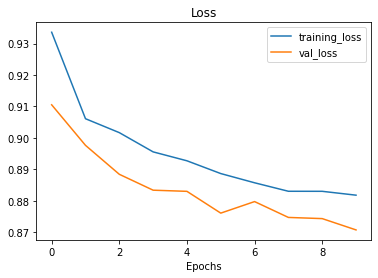

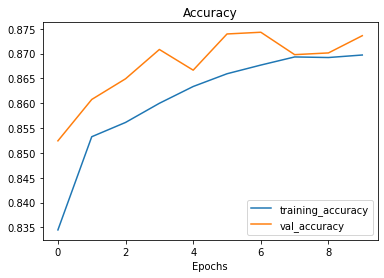

In [54]:
plot_loss_curves(history)

It seems like the model did not overfit.

# Make Predictions on Test Dataset

In [70]:
from helper_functions import calculate_results, make_confusion_matrix
from sklearn.metrics import classification_report

In [55]:
model_preds = tf.argmax(model.predict(test_dataset), axis=1)

461/461 [==============================] - 15s 26ms/step


In [59]:
# calculate results
model_results = calculate_results(y_true=test_labels_encoded,
                                  y_pred=model_preds)

model_results

{'accuracy': 87.41735327026751,
 'precision': 0.8747149245292882,
 'recall': 0.8741735327026752,
 'f1': 0.8724100646391157}

## Classification Report

In [65]:
print(classification_report(y_true=test_labels_encoded,
                            y_pred=model_preds,
                            target_names=class_names))

              precision    recall  f1-score   support

  BACKGROUND       0.72      0.81      0.76      2663
 CONCLUSIONS       0.90      0.86      0.88      4426
     METHODS       0.89      0.94      0.92      9751
   OBJECTIVE       0.83      0.60      0.69      2377
     RESULTS       0.90      0.90      0.90     10276

    accuracy                           0.87     29493
   macro avg       0.85      0.82      0.83     29493
weighted avg       0.87      0.87      0.87     29493



Model is not perfmorming very well on Background and Objective.

## Confusion Matrix

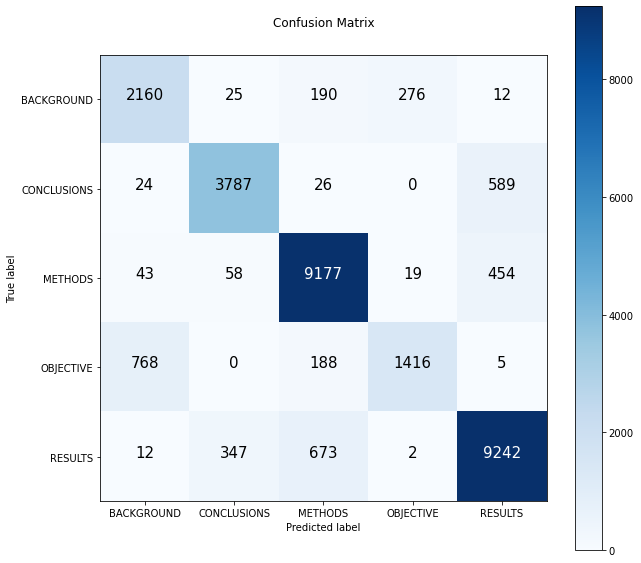

In [87]:
make_confusion_matrix(y_true=test_labels_encoded,
                      y_pred=model_preds,
                      classes=['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'])

> We can see that:

- Objective often gets confused with Background;
- Results often gets confused with Methods;
- Conclusions often gets confused with Results.

Although, the model is not getting a lot of wrong answers. It is getting a lot more of correct results for METHODS and RESULTS because they're more frequent in the dataset comparing to the other classes.

In [89]:
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

# Save Model

In [67]:
# model.save("skimlit_model_200k")

# Make example predictions

## Get example abstracts

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

In [93]:
import json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

In [94]:
abstracts = pd.DataFrame(example_abstracts)
abstracts

,abstract,source,details
0,This RCT examined the efficacy of a manualized...,https://pubmed.ncbi.nlm.nih.gov/20232240/,RCT of a manualized social treatment for high-...
1,Postpartum depression (PPD) is the most preval...,https://pubmed.ncbi.nlm.nih.gov/28012571/,Formatting removed (can be used to compare mod...
2,"Mental illness, including depression, anxiety ...",https://pubmed.ncbi.nlm.nih.gov/28942748/,Effect of nutrition on mental health
3,Hepatitis C virus (HCV) and alcoholic liver di...,https://pubmed.ncbi.nlm.nih.gov/22244707/,Baclofen promotes alcohol abstinence in alcoho...


## Prepare text to enter model

In [95]:
from spacy.lang.en import English

In [109]:
# get the abstract sentences
def get_abstract_sentences(abstract):
  nlp = English()

  sentencizer = nlp.add_pipe("sentencizer")

  doc = nlp(abstract)

  return [str(sent) for sent in list(doc.sents)]

In [110]:
# get texts and line info and put into list of dicts
def get_abstract_txt_and_lines(abstract):
  abstract_lines = get_abstract_sentences(abstract)

  # get total number of lines
  total_lines_in_sample = len(abstract_lines)

  # go through each line and extract features
  sample_lines = []
  for i, line in enumerate(abstract_lines):
    sample_dict = {}
    sample_dict["text"] = str(line)
    sample_dict["line_number"] = i
    sample_dict["total_lines"] = total_lines_in_sample - 1
    sample_lines.append(sample_dict)

  return sample_lines

In [118]:
# one hot encode the line_numbers
def one_hot_lines(abstract, depth):
  sample_lines = get_abstract_txt_and_lines(abstract)

  # get all line_number values from abstract
  test_abstract_line_numbers = [line["line_number"] for line in sample_lines]

  return tf.one_hot(test_abstract_line_numbers, depth)

In [116]:
# get abstract characters
def get_abstract_chars(abstract):
  return [split_chars(sentence) for sentence in get_abstract_sentences(abstract)]

In [147]:
def make_pred_and_show(abstract):
  test_abstract_line_numbers_one_hot = one_hot_lines(abstract, depth=15)
  test_abstract_total_lines_one_hot = one_hot_lines(abstract, depth=20)
  abstract_lines = get_abstract_sentences(abstract)
  abstract_chars = get_abstract_chars(abstract)

  abstract_preds = tf.argmax(model.predict(x=(test_abstract_line_numbers_one_hot,
                                              test_abstract_total_lines_one_hot,
                                              tf.constant(abstract_lines),
                                              tf.constant(abstract_chars)),
                                           verbose=0),
                             axis=1)
  
  abstract_lines = get_abstract_sentences(abstract)
  test_abstract_pred_classes = [label_encoder.classes_[i] for i in abstract_preds]

  for i, line in enumerate(abstract_lines):
    print(f"{test_abstract_pred_classes[i]}: {line}")

Make prediction 1

In [148]:
make_pred_and_show(example_abstracts[0]["abstract"])

OBJECTIVE: This RCT examined the efficacy of a manualized social intervention for children with HFASDs.
METHODS: Participants were randomly assigned to treatment or wait-list conditions.
METHODS: Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language.
METHODS: A response-cost program was applied to reduce problem behaviors and foster skills acquisition.
RESULTS: Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures).
RESULTS: Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents.
RESULTS: High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity.
RESULTS: Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.


Make prediction 2

In [149]:
make_pred_and_show(example_abstracts[1]["abstract"])

BACKGROUND: Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth.
BACKGROUND: No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms.
METHODS: Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet.
METHODS: We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses.
RESULTS: Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms.
RESULTS: Vitamin D: no relevant RCT's were identified,

Make prediction 3

In [150]:
make_pred_and_show(example_abstracts[2]["abstract"])

BACKGROUND: Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden.
BACKGROUND: Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders.
BACKGROUND: There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness.
CONCLUSIONS: This review provides an overview of the nutritional psychiatry field.
CONCLUSIONS: It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research.
CONCLUSIONS: Potential biological path

Make prediction 4

In [151]:
make_pred_and_show(example_abstracts[3]["abstract"])

BACKGROUND: Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world.
BACKGROUND: There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence.
BACKGROUND: Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).
METHODS: Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis.
CONCLUSIONS: The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients.
METHODS: Any patient with HCV infection was selected for this analysis.
RESULTS: Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d.
METHODS: and 12 receiv

# Next Steps

- In order to develop a model with better perfomance, I aim to use the TensorFlow Hub BERT PubMed pretrained embedding instead of the Universal Sequence Encode (USE) one.

- Substitute the Char-Level embedding for a pretrained one.

- Train with more than 10% of the train_dataset.